In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Load dataser
df = pd.read_csv('LFED.csv')

# remove whitespaces from column names
df.columns = df.columns.str.strip()

print(f"Shape of data: {df.shape}")
df.head()

Shape of data: (2938, 22)


,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,...,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,...,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


In [3]:
# Calculate the percentage of missing data per column
missing = df.isnull().mean() * 100
print("\nPercentage of Missing Data:")
print(missing[missing > 0].sort_values(ascending=False))


Percentage of Missing Data:
Population                         22.191967
Hepatitis B                        18.822328
GDP                                15.248468
Total expenditure                   7.692308
Alcohol                             6.603131
Income composition of resources     5.684139
Schooling                           5.547992
thinness 5-9 years                  1.157250
thinness  1-19 years                1.157250
BMI                                 1.157250
Polio                               0.646698
Diphtheria                          0.646698
Life expectancy                     0.340368
Adult Mortality                     0.340368
dtype: float64


# Population has alot of null values along with Hepatitis

In [11]:
# First drop rows where Life Expectancy is null, we can't predict without target values!!!!!
df = df.dropna(subset=['Life expectancy'])

# get all numeric columns
numeric_cols = df.select_dtypes(include=['number']).columns

# Fill with the mean of that specific Country it's more accurate this way :O
for col in numeric_cols:
    df[col] = df[col].fillna(df.groupby('Country')[col].transform('mean'))

# Fill with the mean for remaining nulls based on Status
for col in numeric_cols:
    df[col] = df[col].fillna(df.groupby('Status')[col].transform('mean'))

# Check if any nulls remain (Case: A country had NO data for a column)
remaining_nulls = df[numeric_cols].isnull().sum().sum()
print(f"Remaning Nulls: {remaining_nulls}")

# Double check nulls 
missing = df.isnull().mean() * 100
print("\nPercentage of Missing Data:")
print(missing[missing > 0].sort_values(ascending=False))

# Also Country are useless now ==> we want to learn general trends
df = df.drop(columns=['Country'])

Remaning Nulls: 0

Percentage of Missing Data:
Series([], dtype: float64)


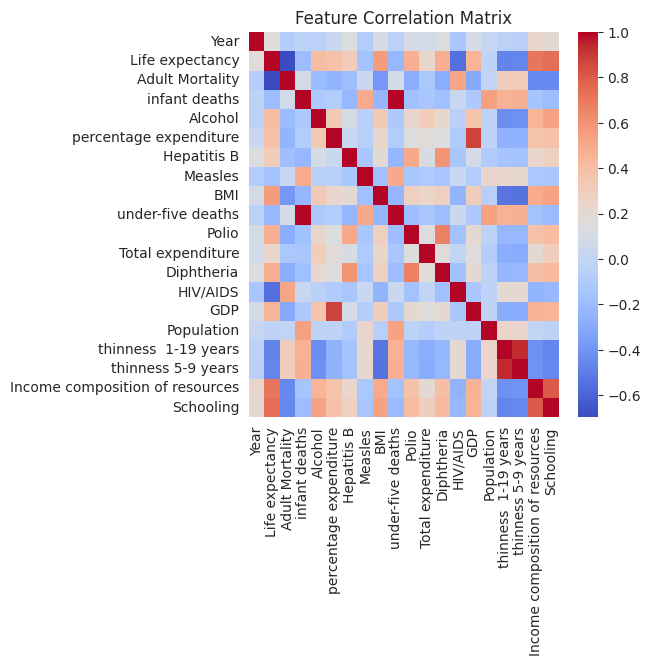

In [12]:
# Set plot style
sns.set_style("whitegrid")

# 1. Correlation Heatmap
plt.figure(figsize=(5,5))
# Calculate correlation matrix
corr = df.select_dtypes(include=['number']).corr()
# Plot heatmap
sns.heatmap(corr, annot=False, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.show()

### We are only interested in 2nd row "Life Expectancy" Blue = unrelated, Red = Related 
### I noticed "Adult Mortality" and "Hiv/ADIS" are deep blue, Which is weird for Hiv/ADIS since it should affect the Life Expectancy ??
### Income and Schooling are major factors

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Developing/Developed ===> 0/1
df['Status'] = df['Status'].map({'Developing': 0, 'Developed': 1})

X = df.drop(columns=['Life expectancy'])
y = df['Life expectancy']

# Train/Test Random Split 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training shapes: X={X_train.shape}, y={y_train.shape}")
print(f"Testing shapes:  X={X_test.shape},  y={y_test.shape}")

Training shapes: X=(2342, 20), y=(2342,)
Testing shapes:  X=(586, 20),  y=(586,)


In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score

############ We need baseline model to compare against XGBoost later ############

# Scale data first
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

# Evaluate
y_pred_lr = lr_model.predict(X_test_scaled)

mae_lr = mean_absolute_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

print(f"Linear Regression\nMAE: {mae_lr:.2f} years\nR²: {r2_lr:.2f}")

Linear Regression
MAE: 2.90 years
R²: 0.82


# Good Shit right here, 0.82 is fine actually But Maybe XGB can do better

In [15]:
import xgboost as xgb

xgb_model = xgb.XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    random_state=42,
    n_jobs=-1
)

xgb_model.fit(X_train, y_train)

# Evaluate
y_pred_xgb = xgb_model.predict(X_test)

mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"XGBoost\nMAE: {mae_xgb:.2f} years\nR²: {r2_xgb:.2f}")

XGBoost
MAE: 1.02 years
R²: 0.97


# :D noice